In [11]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import  Input,Conv2D, MaxPooling2D
from keras.layers import Activation, Dense,Rescaling, MultiHeadAttention,BatchNormalization, Reshape
from tensorflow.keras import activations
from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten,Input, BatchNormalization, GlobalMaxPool1D,LSTM
from keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
import tensorflow_addons as tfa
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import os
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
import scipy.spatial as sp
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from scipy.stats import skew, kurtosis, iqr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_squared_error
from numpy.linalg import norm
from scipy import interpolate
import librosa
from sklearn.preprocessing import StandardScaler


All Input Variables (Classes): 
['air' 'art' 'government' 'health']
---------------------
size of master_dataset_x:  12
dimensions of features in master_dataset_x:  (675, 7)
minimum length of sequence:  192
maximum length of sequence:  675
size of data_X:  12
Unique Labels:  ['class1' 'class2' 'class3']
data_X shape:  (24, 256, 5)
data_Y shape:  (24,)
one_hot_encoded shape:  (24, 3)
 class1  ----------------------------->  [1. 0. 0.]
 class2  ----------------------------->  [0. 1. 0.]
 class3  ----------------------------->  [0. 0. 1.]
X_train shape:  (16, 256, 5)
X_val shape:  (5, 256, 5)
X_test shape:  (3, 256, 5)
y_train shape:  (16, 3)
y_val shape:  (5, 3)
y_test shape:  (3, 3)
Restoring model weights from the end of the best epoch: 12.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch

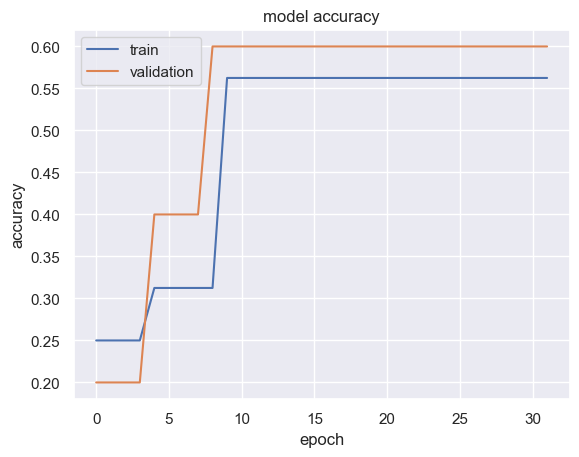

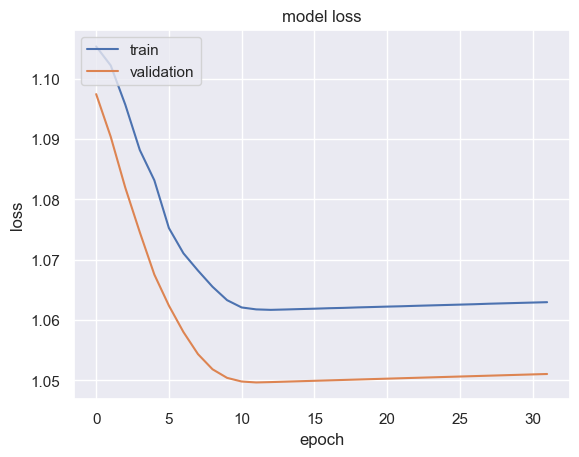

<AxesSubplot: >

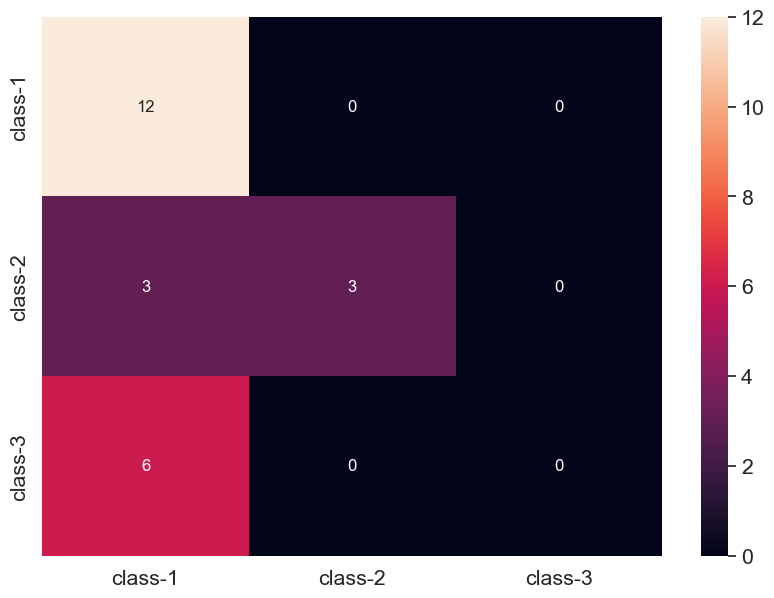

In [12]:
#get list of all file names in directory "data"
file_names = os.listdir(r"D:/Research_work/Trace_Analysis/data5")

#get the part of names in file_names before '-'
input_variables = [name.split('-')[0] for name in file_names]

column_names =['ignore', 'command (read/write)', 'physical address', 'size','gem5 flags', 'timestamp','program_counter']
#find unique elements in input_variables
unique_input_variables = np.unique(input_variables)
print("All Input Variables (Classes): ")
print(unique_input_variables)
print("---------------------")


master_dataset_x=[]
master_dataset_y=[]

for names in file_names:
    #check if names contain string 'icachetrace'
    if 'dcachetrace' in names:
        input_variable=names.split('-')[0] 
        df = pd.read_csv("D:/Research_work/Trace_Analysis/data5/"+ names, sep=',', header=None)
        df.columns = column_names

        #find unique elements in column 'command (read/write)'
        unique_commands=df['command (read/write)'].unique()

        #create dictionary of unique_commands that integer encode the column 'command (read/write)'
        dict_commands = {unique_commands[i]:i for i in range(len(unique_commands))}

        #integer encode 'comand (read/write)' column
        df['command (read/write)'] = df['command (read/write)'].map(dict_commands)

        # convert df to np arrays
        df = df.to_numpy()
        possible_length=len(df)
        master_dataset_x.append(df)
        master_dataset_y.append(input_variable)



print('size of master_dataset_x: ',len(master_dataset_x))
print('dimensions of features in master_dataset_x: ',master_dataset_x[0].shape)


#getting inhomogenous lengths
len_seq=[]
for i in range(len(master_dataset_x)):
    len_seq.append(master_dataset_x[i].shape[0])

min_len_seq=min(len_seq)
print('minimum length of sequence: ',min_len_seq)
max_len_seq=max(len_seq)
print('maximum length of sequence: ',max_len_seq)

#padding zeros
threshold=max_len_seq
for i in range(len(master_dataset_x)):
    #pad zeros if len of sequence is less than threshold
    if master_dataset_x[i].shape[0]<threshold:
        master_dataset_x[i]=np.pad(master_dataset_x[i],((0,threshold-master_dataset_x[i].shape[0]),(0,0)),'constant')



data_X_list=master_dataset_x
data_Y_list=master_dataset_y


#convert to np array
data_X=np.array(data_X_list)
data_Y=np.array(data_Y_list)


#shuffle data
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data_X, data_Y = unison_shuffled_copies(data_X, data_Y)
print('size of data_X: ',len(data_X))



#partition data for now
part=len(data_X)
data_X=data_X[:part]
data_Y=data_Y[:part]




#non-overlapping windows partitioning (creating more data)
window=256
def nearest_multiple(a,window):
    return int(a/window)*window

nearest=nearest_multiple(data_X.shape[1],window)
data_X=data_X[:,:nearest]
Master_data_X=[]
Master_data_Y=[]

for i in range(len(data_X)):
    for j in range(int(data_X.shape[1]/window)):
        part_X=data_X[i][j*window:(j+1)*window,:]
        part_Y=data_Y[i]
        Master_data_X.append(part_X)
        Master_data_Y.append(part_Y)


data_X=np.array(Master_data_X)
data_Y=np.array(Master_data_Y)



#shuffle
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data_X, data_Y = unison_shuffled_copies(data_X, data_Y)


#------------------------------------------------------------------------------------------


Omega_Y_Out=data_Y.copy()

# correcting labels
for i in range(len(data_Y)):
    subject=data_Y[i]
    #check if subject has 10 characters
    if len(subject)<=4:
        data_Y[i]='class1'
    if len(subject)<=6 and len(subject)>4:
        data_Y[i]='class2'
    if len(subject)<=10 and len(subject)>6:
        data_Y[i]='class3'

Omega_Y_In=data_Y.copy()





#slicing some variables
vars_2_keep=[2,3,4,5,6]
data_X=data_X[:,:,vars_2_keep]
num_vars=len(vars_2_keep)
sliced_features=[column_names[i] for i in vars_2_keep]



# #####-------smoothing-----##########
for i in range(len(data_X)):
    for j in range(data_X.shape[2]):
        sig=data_X[i,:,j]
        check_sig=sig.copy()
        smooth_sig=gaussian_filter(sig, sigma=2)
        data_X[i,:,j]=smooth_sig

# ################################


#partition data for now--again
part=len(data_X)
data_X=data_X[:part]
data_Y=data_Y[:part]




print("Unique Labels: ",np.unique(data_Y))
print("data_X shape: ", data_X.shape)
print("data_Y shape: ", data_Y.shape)





#one hot encode data_Y
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data_Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded).astype(float)

print("one_hot_encoded shape: ", onehot_encoded.shape)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," -----------------------------> ",value)



#--------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------



#PCA thingy from my COVID paper

data_X_copy=data_X.copy()
# -----------------sklearn minmax scaler
for i in range(data_X.shape[2]):
    scaler = StandardScaler()
    stranded_data=data_X_copy[:,:,i]
    standardized_stranded_data = scaler.fit_transform(stranded_data)
    data_X[:,:,i]=standardized_stranded_data







#----------------------sine transformation
amp1=1.0
amp2=0.01
for i in range(len(data_X)):
    for j in range(data_X.shape[2]):
        if np.max(data_X[i,:,j])!=0:
            data_X[i,:,j]=data_X[i,:,j]+amp1*np.sin(2*np.pi*data_X[i,:,j]/np.max(data_X[i,:,j]))+amp2*np.random.uniform(low=0.5, high=1.3, size=(data_X.shape[1],))
        else:
            data_X[i,:,j]=data_X[i,:,j]+amp1*np.sin(2*np.pi*data_X[i,:,j])+amp2*np.random.uniform(low=0.5, high=1.3, size=(data_X.shape[1],))


#split data into train, validation, and test sets in percentage 70,20,10
X_train, X_test, y_train, y_test = train_test_split(data_X, onehot_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)


num_classes=y_train.shape[1]
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 100
NUM_CLASSES = num_classes





#compile model
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )




tries=20
check_acc=[]
histories=[]
y_pred_bool_collect=[]
y_ref_bool_collect=[]

for trying in range(tries):
    model = tf.keras.Sequential()
    model.add(LSTM(32, input_shape=(data_X.shape[1], data_X.shape[2]), return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(64, return_sequences=True))
    # model.add(Dropout(0.4))
    model.add(LSTM(64))
    # model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))


    total_steps = int((len(y_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.15
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    #callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

    #train model
    history = model.fit(X_train, y_train, epochs=EPOCHS,batch_size=4, validation_data=(X_val, y_val),verbose=0, callbacks=[early_stopping])
    l,a=model.evaluate(data_X, onehot_encoded, verbose=0)
    y_pred = model.predict(data_X, verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_ref_bool=np.argmax(onehot_encoded, axis=1)
    y_pred_bool_collect.append(y_pred_bool)
    y_ref_bool_collect.append(y_ref_bool)
    check_acc.append(a)
    histories.append(history)


#find argmax of check_acc
ind_max_acc=np.argmax(check_acc)
print("-----------------------------------------")
print("Best accuracy: ", check_acc[ind_max_acc])
print("------------------------------------------")
history=histories[ind_max_acc]



#plot accuracy and loss
sns.set_theme(style="darkgrid")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])   
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



y_pred_bool=y_pred_bool_collect[ind_max_acc]
y_ref_bool=y_ref_bool_collect[ind_max_acc]


cm=confusion_matrix(y_ref_bool,y_pred_bool)


label_names=['class-1','class-2','class-3']

df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
